<a href="https://colab.research.google.com/github/leechanwoo-kor/wine-quality-prediction/blob/main/kaggle/SVM_%E1%84%80%E1%85%AE%E1%84%92%E1%85%A7%E1%86%AB_%2B_%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC_%EA%B2%B0%EA%B3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')  # 그래프 테두리 모두 제거
 
from itertools import combinations
from collections import Counter
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

# Data

In [ ]:
# 데이터 불러오기
url = 'https://raw.githubusercontent.com/leechanwoo-kor/wine-quality-prediction/main/kaggle/WineQT.csv'
df = pd.read_csv(url)
del df['Id']
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


In [ ]:
#categorize wine quality
bins = (2,6.5,8)
group_names = ['bad','good']
categories = pd.cut(df['quality'], bins, labels = group_names)
df['quality'] = categories

In [ ]:
# 데이터 나누기
X = df.drop('quality', axis=1)
y = df.quality

In [ ]:
# Encoding our dependent variable:Quality column
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split # Split test/train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pipeline = Pipeline([
    ('min_max_scaler',MinMaxScaler()),
    ('std_scaler', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Model

In [ ]:
class BinarySVC():
    def __init__(self, kernel=None, coef0=0):
        self.labels_map = None
        self.kernel = kernel
        self.X = None
        self.y = None
        self.alphas = None
        self.w = None
        self.b = None
        self.coef0 = coef0
        if kernel is not None:
            assert kernel in ['poly', 'rbf', 'sigmoid']
    
    def make_label_map(self, uniq_labels):
        labels_map = list(zip([-1, 1], uniq_labels))
        self.labels_map = labels_map
        return
    
    def transform_label(self, label, labels_map):
        res = [l[0] for l in labels_map if l[1] == label][0]
        return res
 
    def inverse_label(self, svm_label, labels_map):
        try:
            res = [l[1] for l in labels_map if l[0] == svm_label][0]
        except:
            print(svm_label)
            print(labels_map)
            raise
        return res
    
    def get_kernel_val(self, x, y):
        X = self.X
        coef0 = self.coef0
        gamma = 1/(X.shape[1]*X.var())
        if self.kernel == 'poly':
            return (gamma*np.dot(x,y)+coef0)**2
        elif self.kernel == 'rbf':
            return np.exp(-gamma*np.square(np.linalg.norm(x-y)))
        else:
            return np.tanh(gamma*np.dot(x,y)+coef0)

    def fit(self, X, y, C):
        assert C >= 0, 'constant C must be non-negative'
        uniq_labels = np.unique(y)
        assert len(uniq_labels) == 2, 'the number of labels is 2'
        self.make_label_map(uniq_labels)
        self.X = X
        y = [self.transform_label(label, self.labels_map) for label in y] ## 1, -1로 변환
        y = np.array(y)
        ## formulating standard form
        m, n = X.shape
        y = y.reshape(-1,1)*1.
        self.y = y
        if self.kernel is not None:
            Q = np.zeros((m,m))
            for i in range(m):
                for j in range(m):
                    Q[i][j] = y[i]*y[j]*self.get_kernel_val(X[i], X[j])                       
        else:
            yX = y*X
            Q = np.dot(yX,yX.T)
        P = cvxopt_matrix(Q)
        q = cvxopt_matrix(-np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        A = cvxopt_matrix(y.reshape(1, -1))
        b = cvxopt_matrix(np.zeros(1))
        ## cvxopt configuration
        cvxopt_solvers.options['show_progress'] = False ## 결과 출력 표시 X
        sol = cvxopt_solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])
        S = (alphas>1e-4).flatten()
        if self.kernel is not None:
            sum_val = 0
            S_index = np.where(S==True)[0]
            for s in S_index:
                temp_vec = np.array([self.get_kernel_val(z, X[s]) for z in X])
                temp_vec = np.expand_dims(temp_vec, axis=1)
                sum_val += np.sum(y[s] - np.sum(y*alphas*temp_vec))
            b = sum_val/len(S)
            self.b = b
        else:
            w = ((y*alphas).T@X).reshape(-1,1)
            b = np.mean(y[S] - np.dot(X[S],w))
            self.w = w
            self.b = b
        self.alphas = alphas
        return

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions
    
    def _predict(self, x):
        if self.kernel:
            temp_vec = np.array([self.get_kernel_val(x, y) for y in self.X])
            temp_vec = np.expand_dims(temp_vec, axis=1)
            S = (self.alphas>1e-4).flatten()
            res = np.sign(np.sum(self.y[S]*self.alphas[S]*temp_vec[S])+self.b)
        else:
            res = np.sign(self.w.T.dot(x)+self.b)
        res = self.inverse_label(res, self.labels_map)
        return res

In [ ]:
class mySVM():
    def __init__(self, svm_type='classification', kernel=None, coef0=0):
        assert svm_type in ['classification', 'regression']
        self.svm_type = svm_type
        self.kernel=kernel
        self.X = None
        self.y = None
        self.coef0 = coef0
        self.model_list = None
        if kernel is not None:
            assert kernel in ['poly', 'rbf', 'sigmoid']

    def get_kernel_val(self, x, y):
        X = self.X
        coef0 = self.coef0
        gamma = 1/(X.shape[1]*X.var())
        if self.kernel == 'poly':
            return (gamma*np.dot(x,y)+coef0)**2
        elif self.kernel == 'rbf':
            return np.exp(-gamma*np.square(np.linalg.norm(x-y)))
        else:
            return np.tanh(gamma*np.dot(x,y)+coef0)

    def fit(self, X, y, C, epsilon=0.1):
        if self.svm_type == 'classification':
            self._fit_svc(X, y, C)
        else:
            self._fit_svr(X, y, C, epsilon)
    
    def _fit_svc(self, X, y, C):
        uniq_labels = np.unique(y)
        label_combinations = list(combinations(uniq_labels, 2))
        model_list = []
        for lc in label_combinations:
            target_idx = np.array([x in lc for x in y])
            y_restricted = y[target_idx]
            X_restricted = X[target_idx]
            clf = BinarySVC(kernel=self.kernel, coef0=self.coef0)
            clf.fit(X_restricted, y_restricted, C)
            model_list.append(clf)
        self.model_list = model_list
        return

    def predict(self, X):
        if self.svm_type =='classification':
            model_list = self.model_list
            prediction = [model.predict(X) for model in model_list]
            prediction = [Counter(pred).most_common(1)[0][0] for pred in list(zip(*prediction))]
        else:
            prediction = [self._predict_reg(x) for x in X]
        return prediction
    
    def _predict_reg(self, x):
        if self.kernel is not None:
            m, _ = self.X.shape
            sol_root = self.alphas
            alphas = sol_root[:m]
            alphas_star = sol_root[m:]
            
            temp_vec = np.array([self.get_kernel_val(z, x) for z in X])
            temp_vec = np.expand_dims(temp_vec, axis=1)
            pred = np.sum((alphas-alphas_star)*temp_vec)+self.b
        else:
            w = self.w
            b = self.b
            pred = w.dot(x)+b
            pred = pred[0]
        return pred

# Train/Test

In [ ]:
clf = mySVM(svm_type='classification')
clf.fit(X_train, y_train, C=10)

In [ ]:
pred = clf.predict(X_test)
np.mean(y_test == pred)

0.8454810495626822

In [ ]:
clf = mySVM(svm_type='classification', kernel='rbf')
clf.fit(X_train, y_train, C=10)

In [ ]:
pred = clf.predict(X_test)
np.mean(y_test == pred)

0.8688046647230321

0.8688046647230321


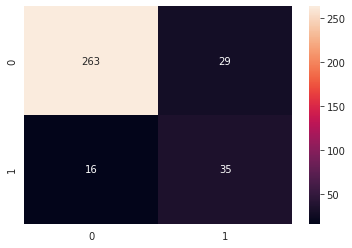

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm,annot=True,fmt='2.0f')
print(accuracy_score(y_test, pred))

### 라이브러리 결과

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(C=10,kernel='rbf')
svm_clf.fit(X_train,y_train)

SVC(C=10)

0.8717201166180758


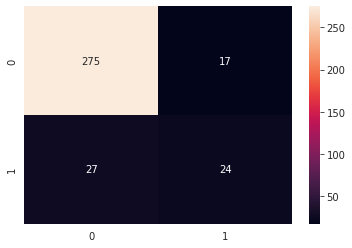

In [ ]:
y_pred = svm_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')
print(accuracy_score(y_pred,y_test))

## Model Comparison

In [ ]:
# For ML models
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC ,SVR
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

model_comparison = {}

### Support Vector Classifier

In [ ]:
parameters = {'C': [6,8,10,12,14], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

svc_model = SVC()

clf = GridSearchCV(svc_model, parameters)
print("Searching for best hyperparameters ...")
clf.fit(X_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(X_test)
model_comparison['SupportVectorClassifier'] = [accuracy_score(y_test,y_pred), f1_score(y_test,y_pred, average='weighted')]
print('\n')
print(classification_report(y_test,y_pred, zero_division=1))

Searching for best hyperparameters ...
Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       0.91      0.94      0.93       292
           1       0.59      0.47      0.52        51

    accuracy                           0.87       343
   macro avg       0.75      0.71      0.72       343
weighted avg       0.86      0.87      0.87       343



### KNeighbors Classifier

In [ ]:
parameters = {'n_neighbors': [10,20,30,40,50]}

K_model = KNeighborsClassifier()

clf = GridSearchCV(K_model, parameters)
print("Searching for best hyperparameters ...")
clf.fit(X_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(X_test)
model_comparison['KNeighborsClassifier'] = [accuracy_score(y_test,y_pred), f1_score(y_test,y_pred, average='weighted')]
print('\n')
print(classification_report(y_test,y_pred, zero_division=1))

Searching for best hyperparameters ...
Best Hyperparameters: {'n_neighbors': 30}


              precision    recall  f1-score   support

           0       0.88      0.99      0.93       292
           1       0.80      0.24      0.36        51

    accuracy                           0.88       343
   macro avg       0.84      0.61      0.65       343
weighted avg       0.87      0.88      0.85       343



### Random Forest Classifier

In [ ]:
parameters = {'n_estimators': [160,180,200], 'max_depth':[20,25,28,30]}

rf = RandomForestClassifier()

clf = GridSearchCV(rf, parameters)
print("Searching for best hyperparameters ...")
clf.fit(X_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(X_test)
model_comparison['RandomForestClassifier'] = [accuracy_score(y_test,y_pred), f1_score(y_test,y_pred, average='weighted')]
print('\n')
print(classification_report(y_test,y_pred, zero_division=1))

Searching for best hyperparameters ...
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 200}


              precision    recall  f1-score   support

           0       0.90      0.98      0.93       292
           1       0.72      0.35      0.47        51

    accuracy                           0.88       343
   macro avg       0.81      0.66      0.70       343
weighted avg       0.87      0.88      0.87       343



### XGBoost

In [ ]:
parameters = {'n_estimators': [100, 150, 200], 'max_depth':[14, 16, 18, 20]}

xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

clf = GridSearchCV(xgboost, parameters)
print("Searching for best hyperparameters ...")
clf.fit(X_train, y_train)
print(f'Best Hyperparameters: {clf.best_params_}')

y_pred = clf.predict(X_test)
model_comparison['XGBoost'] = [accuracy_score(y_test, y_pred), f1_score(y_test,y_pred, average='weighted')]
print('\n')
print(classification_report(y_test,y_pred, zero_division=1))

Searching for best hyperparameters ...
Best Hyperparameters: {'max_depth': 14, 'n_estimators': 150}


              precision    recall  f1-score   support

           0       0.91      0.96      0.93       292
           1       0.63      0.43      0.51        51

    accuracy                           0.88       343
   macro avg       0.77      0.69      0.72       343
weighted avg       0.86      0.88      0.87       343



### Model Comparison

In [ ]:
model_comparison_df = pd.DataFrame.from_dict(model_comparison).T
model_comparison_df.columns = ['Accuracy', 'F1 Score']
model_comparison_df = model_comparison_df.sort_values('F1 Score', ascending=True)
model_comparison_df.style.background_gradient(cmap='Blues')

,Accuracy,F1 Score
KNeighborsClassifier,0.877551,0.847711
SupportVectorClassifier,0.871720,0.865828
RandomForestClassifier,0.883382,0.865919
XGBoost,0.877551,0.867793


In [ ]:
# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure(data=[
    go.Bar(name='F1 Score', y=model_comparison_df.index, x=model_comparison_df['F1 Score'], orientation='h'),
    go.Bar(name='Accuracy', y=model_comparison_df.index, x=model_comparison_df['Accuracy'], orientation='h')
])
fig.update_layout(barmode='group')
fig.show()